In [ ]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

## Data preprocessing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data_train=pd.read_csv('/content/drive/MyDrive/AML_assignment_2/UNSW_NB15_training-set.csv')
data_test=pd.read_csv('/content/drive/MyDrive/AML_assignment_2/UNSW_NB15_testing-set.csv')

In [ ]:
data=pd.concat([data_train,data_test],ignore_index=True)
y=data['attack cat']
data.drop('attack cat',axis=1,inplace=True)
data.drop('label',axis=1,inplace=True)

### Exploring metrics

In [ ]:
unique_cat={}
cat_features=[]
for column in data.columns:
  if len(data[column].unique())<=12:
    unique_cat[column]=data[column].value_counts()/data.shape[0]
  if type(data[column][3])==str:
    cat_features.append(column)


In [ ]:
for key in unique_cat:
  print(unique_cat[key])

FIN    0.454700
INT    0.451883
CON    0.078138
REQ    0.014875
RST    0.000326
ECO    0.000047
ACC    0.000016
CLO    0.000004
PAR    0.000004
URN    0.000004
no     0.000004
Name: state, dtype: float64
0      0.467410
252    0.310172
29     0.217807
60     0.004238
30     0.000167
31     0.000147
253    0.000035
32     0.000016
254    0.000008
Name: dttl, dtype: float64
2    0.450781
1    0.297233
0    0.224455
6    0.014491
3    0.012927
4    0.000109
5    0.000004
Name: ct_state_ttl, dtype: float64
0    0.987407
1    0.012493
4    0.000062
2    0.000039
Name: is_ftp_login, dtype: float64
0    0.987399
1    0.012477
2    0.000062
4    0.000062
Name: ct_ftp_cmd, dtype: float64
0     0.901348
1     0.091604
4     0.005138
9     0.000838
2     0.000357
16    0.000186
6     0.000163
12    0.000140
30    0.000116
25    0.000097
3     0.000012
Name: ct_flw_http_mthd, dtype: float64
0    0.985726
1    0.014274
Name: is_sm_ips_ports, dtype: float64
Normal            0.360923
Generic        

We can see that for 'is_sm_ips_ports', 'ct_ftp_cmd', 'is_ftp_login' more than 98% of column equals to specififc value. So we can remove these features. Also we exclude 'proto' because it contains more than 130 unique 

In [ ]:
constant_columns=['is_sm_ips_ports', 'ct_ftp_cmd', 'is_ftp_login','proto']
data.drop(columns=constant_columns,inplace=True)


In [ ]:
cat_features.remove('proto')

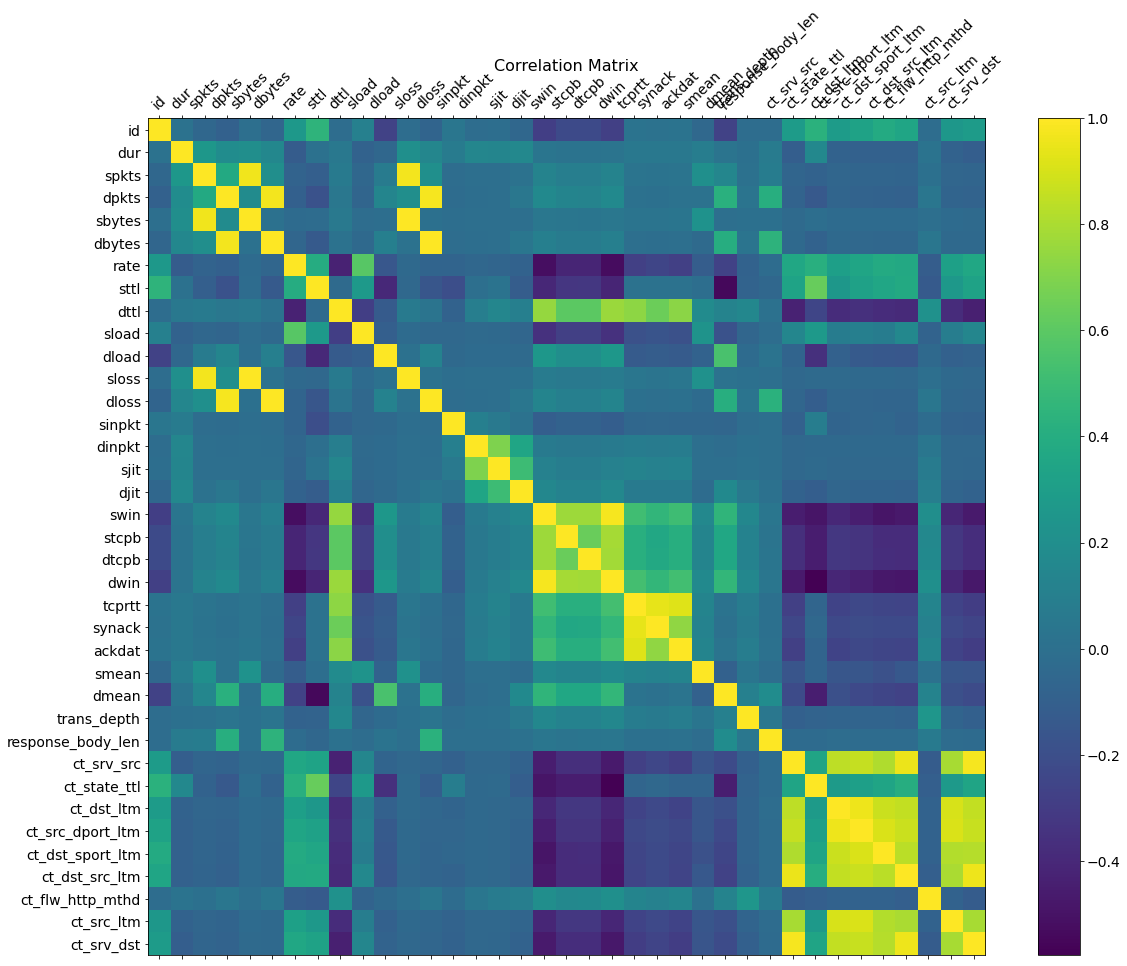

In [ ]:
f = plt.figure(figsize=(19, 15))
df=data
plt.matshow(df.corr(), fignum=f.number)
plt.xticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0c4857bf10>,
      dtype=object)

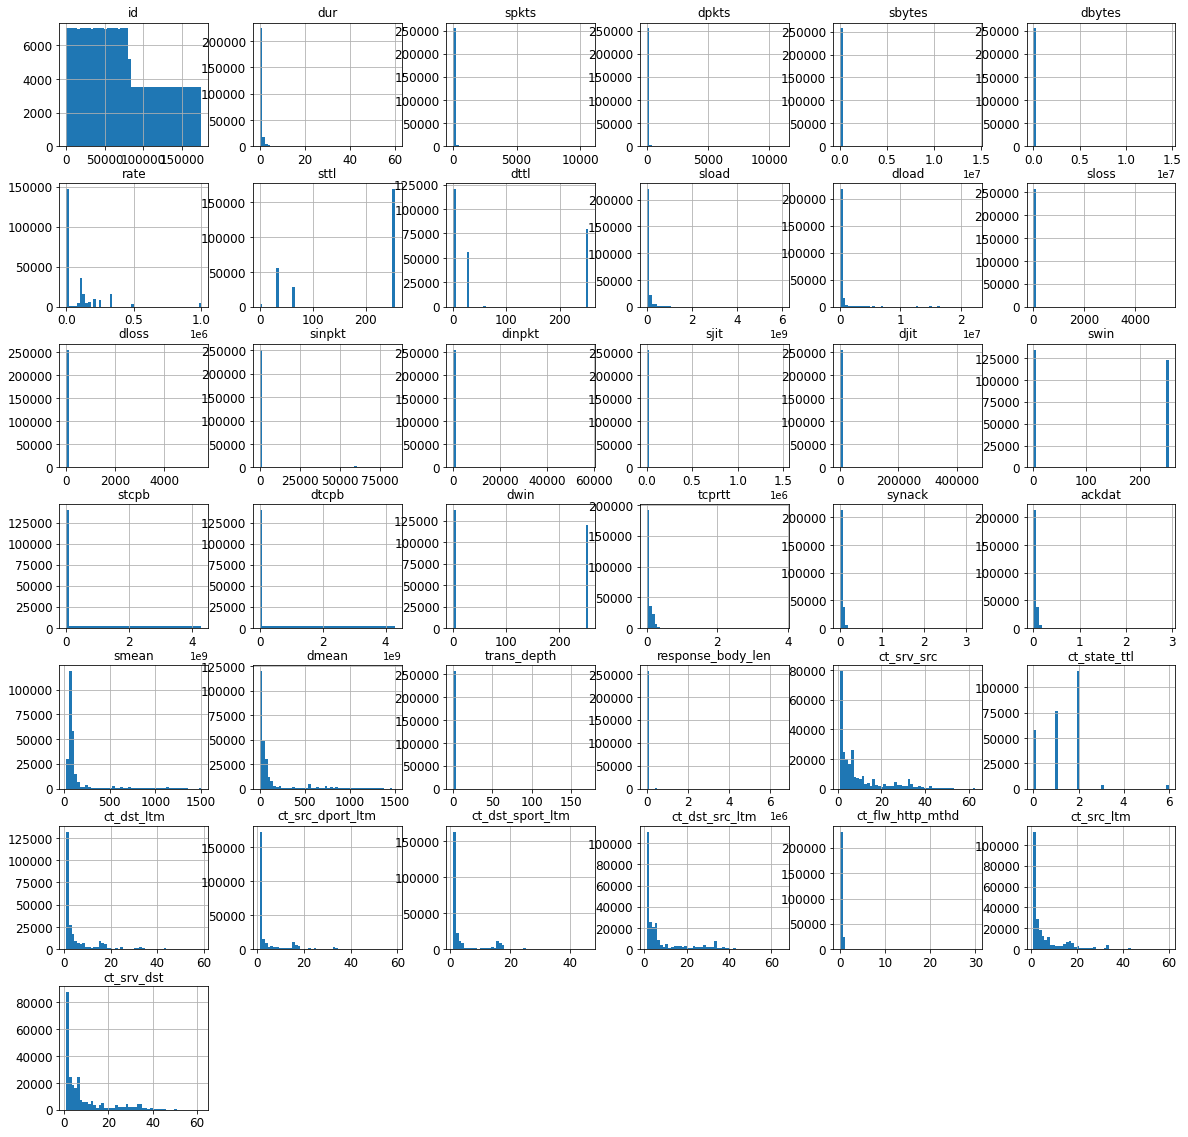

In [ ]:
data.hist(figsize=(20, 20), bins=50, xlabelsize=12, ylabelsize=12)

### Fill missing values

In [ ]:
from sklearn.impute import SimpleImputer
for column in data.columns[1:]: 
  imp_mean = SimpleImputer( strategy='most_frequent')
  imp_mean.fit(np.array(data[column]).reshape(-1,1))
  data[column]=imp_mean.transform(np.array(data[column]).reshape(-1,1))



In [ ]:
# from sklearn.preprocessing import LabelEncoder
# for cat in cat_features:
#   encoder=LabelEncoder()

#   data[cat]=encoder.fit_transform(data[cat])

data=pd.get_dummies(data,columns=cat_features)


In [ ]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
data = scaler.fit_transform(data)


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( data, y, test_size=0.2, random_state=42)

## Conditional GAN

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
device

device(type='cuda', index=0)

In [ ]:
data_size=X_train.shape[1]
n_classes=2


In [ ]:
from torch.utils.data import Dataset, DataLoader

class df(Dataset):
    def __init__(self, X, y, transform=None):
        self.transform = transform
        self.labels = y
        self.data=X

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        label = self.labels[idx]
        data=self.data[idx]
        
        if self.transform:
            data = self.transform(data)

        return data, label

In [ ]:

## Undercomplete
class Generator(nn.Module):
    def __init__(self, data_size=data_size,n_classes=n_classes):
      super(Generator, self).__init__()

      self.label_emb = nn.Embedding(n_classes, n_classes)
      input_size=n_classes + data_size
      self.hidden_layer1 = nn.Sequential(
          nn.Linear(input_size, 128),
          nn.LeakyReLU(0.2)

      )

      self.hidden_layer2 = nn.Sequential(
          nn.Linear(128, 256),
          nn.LeakyReLU(0.2)

      )
      self.hidden_layer3 = nn.Sequential(
          nn.Linear(256, 512),
          nn.LeakyReLU(0.2),

      )
      self.hidden_layer4 = nn.Sequential(
          nn.Linear(512, data_size),
          nn.Tanh()

      )

        

        
    def forward(self, data,labels,n_classes=2):

      get_input = torch.cat((self.label_emb(labels.to(device)), data.to(device)), -1)
      x = get_input
      output=self.hidden_layer1(x)
      output=self.hidden_layer2(output)
      output=self.hidden_layer3(output)
      output=self.hidden_layer4(output)
      return output.to(device)
        
        
    
class Discriminator(nn.Module):
    def __init__(self, data_size=data_size,n_classes=n_classes):

      super(Discriminator, self).__init__()
      self.label_emb = nn.Embedding(n_classes, n_classes)
      # Step 1 : Define the encoder 
      # Step 2 : Define the decoder
      # Step 3 : Initialize the weights (optional)
      input_size = n_classes + data_size

      self.hidden_layer1 = nn.Sequential(
          nn.Linear(input_size, 512),
          nn.LeakyReLU(0.2),
          nn.Dropout(0.3)

      )

      self.hidden_layer2 = nn.Sequential(
          nn.Linear(512, 256),
          nn.LeakyReLU(0.2),
          nn.Dropout(0.3)

      )
      self.hidden_layer3 = nn.Sequential(
          nn.Linear(256, 128),
          nn.LeakyReLU(0.2),
          nn.Dropout(0.3)

      )
      self.hidden_layer4 = nn.Sequential(
          nn.Linear(128,1)

      )

        

        
    def forward(self, data,labels):
      # Step 1: Pass the input through encoder to get latent representation
      # Step 2: Take latent representation and pass through decoder
      get_input = torch.cat((self.label_emb(labels), data), -1)
      x = get_input
      output=self.hidden_layer1(x)
      output=self.hidden_layer2(output)
      output=self.hidden_layer3(output)
      output=self.hidden_layer4(output)
      return output.to(device)
        


In [ ]:
batchSize=50
learning_rate = 0.0005
num_epochs = 40
generator=Generator()
discriminator=Discriminator()
if torch.cuda.is_available():
  generator.cuda()
  discriminator.cuda()

# print(summary(AE,input_size=(1, 64)))

criterion_gen = nn.MSELoss()
criterion=nn.CrossEntropyLoss()
if torch.cuda.is_available():
  criterion.cuda()
  criterion_gen.cuda()
X_tensor_train = torch.tensor(X_train).float().to(device)
X_tensor_test = torch.tensor(X_test).float().to(device)
y_tensor_train = torch.tensor(y_train.values).float().to(device)
y_tensor_test = torch.tensor(y_test.values).float().to(device)



data_loader = DataLoader(df(X_tensor_train,y_tensor_train),batch_size=batchSize,shuffle=True)

gen_optimizer = torch.optim.Adam(generator.parameters(), lr=learning_rate)
dis_optimizer = torch.optim.Adam(discriminator.parameters(), lr=learning_rate)
#Create a random dataset
# del full_train

In [ ]:
torch.cuda.is_available()

True

In [ ]:
FloatTensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if torch.cuda.is_available() else torch.LongTensor

In [ ]:
from torch.autograd import Variable

In [ ]:
losses=[]


from tqdm import tqdm

for epoch in tqdm(range(num_epochs)):
  gen_losses=[]
  dis_losses=[]

  for i, (x,y) in enumerate(data_loader):

      batch_size = x.shape[0]

      # Adversarial ground truths
      valid = Variable(FloatTensor(batch_size, 1).fill_(1.0), requires_grad=False)
      fake = Variable(FloatTensor(batch_size, 1).fill_(0.0), requires_grad=False)

      # Configure input
      real_data = Variable(x.type(FloatTensor))
      labels = Variable(y.type(LongTensor))

      # -----------------
      #  Train Generator
      # -----------------

      gen_optimizer.zero_grad()

      # Sample noise and labels as generator input
      z = Variable(FloatTensor(np.random.normal(0, 1, (batch_size, data.shape[1]))))
      gen_labels = Variable(LongTensor(np.random.randint(0, n_classes,batch_size)))

      # Generate new data
      gen_imgs = generator(z.to(device), gen_labels.to(device))

      # Loss measures generator's ability to fool the discriminator
      validity = discriminator(gen_imgs, gen_labels)
      g_loss = criterion_gen(validity, valid)
      gen_losses.append(g_loss.item())
      g_loss.backward()
      gen_optimizer.step()

      # ---------------------
      #  Train Discriminator
      # ---------------------

      dis_optimizer.zero_grad()

      # Loss for real data
      validity_real = discriminator(real_data, labels)
      d_real_loss = criterion(validity_real, valid)

      # Loss for fake data
      validity_fake = discriminator(gen_imgs.detach(), gen_labels)
      d_fake_loss = criterion(validity_fake, fake)

      # Total discriminator loss
      d_loss = (d_real_loss + d_fake_loss) / 2
      dis_losses.append(d_loss.item())
      d_loss.backward()
      dis_optimizer.step()
      # if i%0==0:
      #   print(
      #       "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
      #       % (epoch, num_epochs, i, len(data_loader), d_loss.item(), g_loss.item())
      #   )

      # batches_done = epoch * len(data_loader) + i
  losses.append((np.mean(gen_losses)+np.mean(dis_losses)))

        # if batches_done % opt.sample_interval == 0:
        #     sample_image(n_row=10, batches_done=batches_done)
  # log
  print('epoch [{}/{}], loss:{:.4f}'.format(epoch + 1, num_epochs, d_loss.item()))

  2%|▎         | 1/40 [00:29<19:22, 29.82s/it]

epoch [1/40], loss:-0.0000


  5%|▌         | 2/40 [01:00<19:17, 30.46s/it]

epoch [2/40], loss:-0.0000


  8%|▊         | 3/40 [01:31<18:46, 30.44s/it]

epoch [3/40], loss:-0.0000


 10%|█         | 4/40 [02:00<18:02, 30.06s/it]

epoch [4/40], loss:-0.0000


 12%|█▎        | 5/40 [02:30<17:25, 29.88s/it]

epoch [5/40], loss:-0.0000


 15%|█▌        | 6/40 [03:00<17:05, 30.16s/it]

epoch [6/40], loss:-0.0000


 18%|█▊        | 7/40 [03:31<16:36, 30.21s/it]

epoch [7/40], loss:-0.0000


 20%|██        | 8/40 [04:00<15:59, 29.98s/it]

epoch [8/40], loss:-0.0000


 22%|██▎       | 9/40 [04:30<15:29, 29.98s/it]

epoch [9/40], loss:-0.0000


 25%|██▌       | 10/40 [05:01<15:05, 30.18s/it]

epoch [10/40], loss:-0.0000


 28%|██▊       | 11/40 [05:31<14:31, 30.06s/it]

epoch [11/40], loss:-0.0000


 30%|███       | 12/40 [06:00<13:59, 29.97s/it]

epoch [12/40], loss:-0.0000


 32%|███▎      | 13/40 [06:31<13:31, 30.04s/it]

epoch [13/40], loss:-0.0000


 35%|███▌      | 14/40 [07:01<13:04, 30.18s/it]

epoch [14/40], loss:-0.0000


 38%|███▊      | 15/40 [07:31<12:29, 29.99s/it]

epoch [15/40], loss:-0.0000


 40%|████      | 16/40 [08:00<11:55, 29.82s/it]

epoch [16/40], loss:-0.0000


 42%|████▎     | 17/40 [08:30<11:28, 29.93s/it]

epoch [17/40], loss:-0.0000


 45%|████▌     | 18/40 [09:00<11:00, 30.02s/it]

epoch [18/40], loss:-0.0000


 48%|████▊     | 19/40 [09:30<10:26, 29.83s/it]

epoch [19/40], loss:-0.0000


 50%|█████     | 20/40 [09:59<09:55, 29.75s/it]

epoch [20/40], loss:-0.0000


 52%|█████▎    | 21/40 [10:30<09:29, 29.98s/it]

epoch [21/40], loss:-0.0000


 55%|█████▌    | 22/40 [11:00<08:58, 29.93s/it]

epoch [22/40], loss:-0.0000


 57%|█████▊    | 23/40 [11:29<08:26, 29.81s/it]

epoch [23/40], loss:-0.0000


 60%|██████    | 24/40 [11:59<07:56, 29.81s/it]

epoch [24/40], loss:-0.0000


 62%|██████▎   | 25/40 [12:30<07:30, 30.02s/it]

epoch [25/40], loss:-0.0000


 65%|██████▌   | 26/40 [12:59<06:59, 29.93s/it]

epoch [26/40], loss:-0.0000


 68%|██████▊   | 27/40 [13:29<06:27, 29.81s/it]

epoch [27/40], loss:-0.0000


 70%|███████   | 28/40 [13:59<05:59, 29.98s/it]

epoch [28/40], loss:-0.0000


 72%|███████▎  | 29/40 [14:30<05:31, 30.12s/it]

epoch [29/40], loss:-0.0000


 75%|███████▌  | 30/40 [14:59<04:58, 29.87s/it]

epoch [30/40], loss:-0.0000


 78%|███████▊  | 31/40 [15:29<04:28, 29.83s/it]

epoch [31/40], loss:-0.0000


 80%|████████  | 32/40 [15:59<04:00, 30.04s/it]

epoch [32/40], loss:-0.0000


 82%|████████▎ | 33/40 [16:29<03:30, 30.12s/it]

epoch [33/40], loss:-0.0000


 85%|████████▌ | 34/40 [16:59<02:59, 29.94s/it]

epoch [34/40], loss:-0.0000


 88%|████████▊ | 35/40 [17:29<02:29, 29.90s/it]

epoch [35/40], loss:-0.0000


 90%|█████████ | 36/40 [18:00<02:01, 30.35s/it]

epoch [36/40], loss:-0.0000


 92%|█████████▎| 37/40 [18:30<01:30, 30.33s/it]

epoch [37/40], loss:-0.0000


 95%|█████████▌| 38/40 [19:00<01:00, 30.08s/it]

epoch [38/40], loss:-0.0000


 98%|█████████▊| 39/40 [19:30<00:29, 29.99s/it]

epoch [39/40], loss:-0.0000


100%|██████████| 40/40 [19:59<00:00, 29.99s/it]

epoch [40/40], loss:-0.0000


In [ ]:

torch.save(generator, '/content/drive/MyDrive/AML_assignment_2/gen.pth')
torch.save(discriminator, '/content/drive/MyDrive/AML_assignment_2/dis.pth')

In [ ]:
gen=torch.load( '/content/drive/MyDrive/AML_assignment_2/gen.pth')
dis=torch.load( '/content/drive/MyDrive/AML_assignment_2/dis.pth')

### Discriminator loss

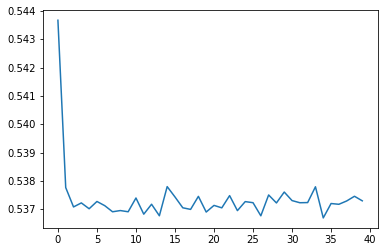

In [ ]:

temp=[loss for loss in losses ]
plt.plot(range(len(temp)),temp)

### Save losses

In [ ]:
l={}
l['dis loss']=losses



In [ ]:
l_fd=pd.DataFrame(l)

In [ ]:
l_fd.to_csv('/content/drive/MyDrive/AML_assignment_2/loss.csv')

After generating the network intrusion and balanced the data, it is important to see if balancing the data helped to improve a ML classifier perfomence. There are a lot of ML classifiers that can be used. For this assignment we will only take 3 into consideration. The 3 classifiers are Random Forest, Explainable Boosting Machine and Classical Neural Network.



### Balance data. Generate new observations with labels equal to 0.

In [ ]:
disbalance=y_train.value_counts()[1]-y_train.value_counts()[0]

In [ ]:
disbalance

57488

In [ ]:
import random
#Generate to noise to input of generator

z = Variable(FloatTensor(np.random.normal(0, 1, (57000, data.shape[1]))))
gen_labels = Variable(LongTensor(np.zeros(57000)))

with torch.no_grad():
  new_data = gen(z, gen_labels).cpu().numpy()

In [ ]:
X_train_ext = np.vstack((X_train, new_data))
y_train_ext = np.hstack((y_train, np.zeros(57000)))

In [ ]:
y_train.value_counts()

1    131813
0     74325
Name: label, dtype: int64

In [ ]:
np.unique(y_train_ext, return_counts=True)

(array([0., 1.]), array([131325, 131813]))

### Compare metrics of classification for extended dataset and dataset without generated data.

After generating the network intrusion and balanced the data, We will check if balancing the data helped to improve a ML classifier perfomence. For this assignment we will only take 3 into consideration. The 3 classifiers are Random Forest, Explainable Boosting Machine and Classical Neural Network.

In [ ]:
#pip install interpret

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from interpret.glassbox import ExplainableBoostingClassifier

In [ ]:
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

In [ ]:
from sklearn.model_selection import cross_validate
def cross_validation(model, _X, _y, _cv=5):
      '''Function to perform 5 Folds Cross-Validation
       Parameters
       ----------
      model: Python Class, default=None
              This is the machine learning algorithm to be used for training.
      _X: array
           This is the matrix of features.
      _y: array
           This is the target variable.
      _cv: int, default=5
          Determines the number of folds for cross-validation.
       Returns
       -------
       The function returns a dictionary containing the metrics 'accuracy', 'precision',
       'recall', 'f1' for both training set and validation set.
      '''
      _scoring = ['accuracy', 'precision', 'recall', 'f1']
      results = cross_validate(estimator=model,
                               X=_X,
                               y=_y,
                               cv=_cv,
                               scoring=_scoring,
                               return_train_score=True)
      
      return {"Training Accuracy scores": results['train_accuracy'],
              "Mean Training Accuracy": results['train_accuracy'].mean()*100,
              "Training Precision scores": results['train_precision'],
              "Mean Training Precision": results['train_precision'].mean(),
              "Training Recall scores": results['train_recall'],
              "Mean Training Recall": results['train_recall'].mean(),
              "Training F1 scores": results['train_f1'],
              "Mean Training F1 Score": results['train_f1'].mean(),
              "Validation Accuracy scores": results['test_accuracy'],
              "Mean Validation Accuracy": results['test_accuracy'].mean()*100,
              "Validation Precision scores": results['test_precision'],
              "Mean Validation Precision": results['test_precision'].mean(),
              "Validation Recall scores": results['test_recall'],
              "Mean Validation Recall": results['test_recall'].mean(),
              "Validation F1 scores": results['test_f1'],
              "Mean Validation F1 Score": results['test_f1'].mean()
              }

### Random forest classifier

 without extended data

In [ ]:
print('Random forest')
rfc=RandomForestClassifier()
# rfc.fit(X_train,y_train)
# y_pred = rfc.predict(X_test)
# print(classification_report(y_test, y_pred))
rfc_res=cross_validation(rfc, X_train, y_train, _cv=5)

Random forest


In [ ]:
rfc_res

{'Training Accuracy scores': array([1., 1., 1., 1., 1.]),
 'Mean Training Accuracy': 100.0,
 'Training Precision scores': array([1., 1., 1., 1., 1.]),
 'Mean Training Precision': 1.0,
 'Training Recall scores': array([1., 1., 1., 1., 1.]),
 'Mean Training Recall': 1.0,
 'Training F1 scores': array([1., 1., 1., 1., 1.]),
 'Mean Training F1 Score': 1.0,
 'Validation Accuracy scores': array([1., 1., 1., 1., 1.]),
 'Mean Validation Accuracy': 100.0,
 'Validation Precision scores': array([1., 1., 1., 1., 1.]),
 'Mean Validation Precision': 1.0,
 'Validation Recall scores': array([1., 1., 1., 1., 1.]),
 'Mean Validation Recall': 1.0,
 'Validation F1 scores': array([1., 1., 1., 1., 1.]),
 'Mean Validation F1 Score': 1.0}

Add extended data

In [ ]:
print('Random forest')
rfc=RandomForestClassifier()
rfc.fit(X_train_ext,y_train_ext)
y_pred = rfc.predict(X_test)
print(classification_report(y_test, y_pred))

Random forest
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18675
           1       1.00      1.00      1.00     32860

    accuracy                           1.00     51535
   macro avg       1.00      1.00      1.00     51535
weighted avg       1.00      1.00      1.00     51535



### MLPClassifier

Without synthetic data

In [ ]:
mpl = MLPClassifier(hidden_layer_sizes=(50))
print(cross_validation(mpl, X_train, y_train, _cv=5))

{'Training Accuracy scores': array([0.99725305, 0.99839306, 0.99710145, 0.99773211, 0.99853861]), 'Mean Training Accuracy': 99.78036549988288, 'Training Precision scores': array([0.99636931, 0.99823792, 0.99965729, 0.99663481, 0.99955367]), 'Mean Training Precision': 0.9980905997230469, 'Training Recall scores': array([0.99934566, 0.99925083, 0.99580844, 0.9998293 , 0.99816028]), 'Mean Training Recall': 0.9984789037655997, 'Training F1 scores': array([0.99785527, 0.99874412, 0.99772915, 0.9982295 , 0.99885649]), 'Mean Training F1 Score': 0.9982829058006756, 'Validation Accuracy scores': array([0.99755021, 0.99805957, 0.99755021, 0.99793824, 0.99837485]), 'Mean Validation Accuracy': 99.78946168288336, 'Validation Precision scores': array([0.99685939, 0.99784066, 0.99977164, 0.99701154, 0.99939226]), 'Mean Validation Precision': 0.99817509785162, 'Validation Recall scores': array([0.99931722, 0.99912757, 0.99639646, 0.9997724 , 0.9980654 ]), 'Mean Validation Recall': 0.9985358103235354, 

With extended data

In [ ]:
mpl = MLPClassifier(hidden_layer_sizes=(50))
print(cross_validation(mpl, X_train_ext, y_train_ext, _cv=5))

{'Training Accuracy scores': array([0.99859864, 0.99858914, 0.99845613, 0.99899768, 0.99922094]), 'Mean Training Accuracy': 99.87725065615692, 'Training Precision scores': array([0.99723848, 0.99731368, 0.99706842, 0.99980054, 0.99863604]), 'Mean Training Precision': 0.9980114326621112, 'Training Recall scores': array([0.99997155, 0.99987672, 0.99985775, 0.99819822, 0.99981034]), 'Mean Training Recall': 0.9995429151094287, 'Training F1 scores': array([0.99860315, 0.99859356, 0.99846114, 0.99899873, 0.99922284]), 'Mean Training F1 Score': 0.9987758838415907, 'Validation Accuracy scores': array([0.9970548 , 0.99692179, 0.99726381, 0.99868889, 0.99982899]), 'Mean Validation Accuracy': 99.79516550804554, 'Validation Precision scores': array([0.99419219, 0.99422794, 0.99479147, 0.99980991, 0.99992412]), 'Mean Validation Precision': 0.9965891244346503, 'Validation Recall scores': array([0.99996207, 0.99965861, 0.99977241, 0.99757226, 0.99973447]), 'Mean Validation Recall': 0.9993399636363796

ExplainableBoostingClassifier

In [ ]:
ebc = ExplainableBoostingClassifier()
cross_validation(mpl, X_train, y_train, _cv=5)

{'Training Accuracy scores': array([0.99763507, 0.99885998, 0.99617367, 0.9980535 , 0.99670125]),
 'Mean Training Accuracy': 99.74846949793867,
 'Training Precision scores': array([0.99644653, 0.99981956, 0.99986647, 0.99734133, 0.999838  ]),
 'Mean Training Precision': 0.9986623797364131,
 'Training Recall scores': array([0.99986724, 0.99839734, 0.99414889, 0.99962068, 0.99500242]),
 'Mean Training Recall': 0.9974073122368988,
 'Training F1 scores': array([0.99815395, 0.99910795, 0.99699948, 0.9984797 , 0.99741435]),
 'Mean Training F1 Score': 0.99803108683872,
 'Validation Accuracy scores': array([0.99772   , 0.99878723, 0.99626467, 0.99808378, 0.99694375]),
 'Mean Validation Accuracy': 99.75598866184656,
 'Validation Precision scores': array([0.99674748, 0.99984803, 0.99969495, 0.99742609, 0.99977141]),
 'Mean Validation Precision': 0.9986975918363565,
 'Validation Recall scores': array([0.99969654, 0.99825513, 0.99446194, 0.99958273, 0.99544799]),
 'Mean Validation Recall': 0.99748

In [ ]:
ebc = ExplainableBoostingClassifier()
print(cross_validation(mpl, X_train_ext, y_train_ext, _cv=5))

{'Training Accuracy scores': array([0.99856064, 0.99636122, 0.99857964, 0.99790035, 0.99796685]), 'Mean Training Accuracy': 99.7873739140944, 'Training Precision scores': array([0.99721006, 0.99941797, 0.99718195, 0.99582598, 0.99598576]), 'Mean Training Precision': 0.9971243432244277, 'Training Recall scores': array([0.99992413, 0.99331437, 0.99999052, 1.        , 0.99997155]), 'Mean Training Recall': 0.9986401138519663, 'Training F1 scores': array([0.99856525, 0.99635682, 0.99858426, 0.99790862, 0.99797467]), 'Mean Training F1 Score': 0.9978779263635541, 'Validation Accuracy scores': array([0.99692179, 0.99631375, 0.99739682, 0.99988599, 0.999981  ]), 'Mean Validation Accuracy': 99.80998702857354, 'Validation Precision scores': array([0.9940043 , 0.99881819, 0.99490489, 0.99984828, 1.        ]), 'Mean Validation Precision': 0.9975151320558165, 'Validation Recall scores': array([0.9998862 , 0.99381709, 0.99992414, 0.99992413, 0.99996207]), 'Mean Validation Recall': 0.9987027264438785,

In [ ]:
ebс_global = ebс.explain_global(name='EBM')
show(ebс_global)